## Linear Regression: Ridge Regression and LASSO

**Functions**

`sklearn.linear_model.RidgeCV`, `sklearn.linear_model.LassoCV`, `sklearn.preprocessing.StandardScaler`


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, RidgeCV

### Exercise 49

Standardize the value-weighted-market return data and the 12 industry portfolios by their standard deviation. You should _not_ remove the mean since we want to match the mean in the tracking portfolio.

In [2]:
vwm = pd.read_csv("data/VWM.csv", index_col="Date")
vwm.index = pd.to_datetime(vwm.index, format="%Y%m")
vwm = vwm.resample("M").last()

industries = pd.read_csv("data/12_Industry_portfolios.csv", index_col="Date")
industries.index = pd.to_datetime(industries.index, format="%Y%m")
industries = industries.resample("M").last()

In [3]:
x = industries["1980":"2014"]
y = vwm["VWM"]["1980":"2014"]
t, p = x.shape

#### Explanation

Here we use the same problem (portfolio tracking) and data that was used in the Best Subset and Stepwise regression notebook.

In [4]:
x_scale = x.std(ddof=0)
y_scale = y.std(ddof=0)
std_x = x / x_scale
std_y = y / y_scale

#### Explanation

We standardize the data by dividing by the the standard deviation. Note that we do not remove the mean since the portfolio tracking problem excludes an intercept.  The transformed data is then

$$ \tilde{X} = \frac{X - 0}{\hat{\sigma}} $$

where the mean has been replaced by 0 since we are _not_ recentering.

**Note**: We set `ddof=0` so that the large-sample standard deviation estimator is used, 
$$\hat{\sigma} = \sqrt{n^{-1} \sum_{i=1}^n (X_i - \bar{X})^2}$$

### Exercise 50

Select the optimal tuning parameter in a LASSO and estimate model parameters for the tracking error minimizing portfolio using the standardized data.

In [5]:
lasso_cv = LassoCV(fit_intercept=False)
lasso_cv = lasso_cv.fit(std_x, std_y)
print(f"Optimal alpha : {lasso_cv.alpha_}")
lasso_cv.coef_

Optimal alpha : 0.0009720286574532111


array([ 0.05005624, -0.01018175,  0.09781553,  0.11926269,  0.03592871,
        0.31908609,  0.10457203,  0.0279572 ,  0.06254488,  0.08440358,
        0.17082026,  0.13580386])

#### Explanation

`LassoCV` can be used to cross-validate the tuning parameter (`alpha` is scikit-learn is the same as $\lambda$ in the notes). Here we set `fit_intercept` to `False` since the model should not include an intercept.  We then choose the tuning parameter by cross-validation and report the optimal value and the estimated coefficients.

### Exercise 51

Transform the estimated LASSO coefficients back to the scale of the original, non-standardized data.

In [6]:
lasso_orig = lasso_cv.coef_ * (y_scale / x_scale)
lasso_orig

NoDur    0.054173
Durbl   -0.006784
Manuf    0.081264
Enrgy    0.094259
Chems    0.035066
BusEq    0.207187
Telcm    0.093599
Utils    0.031835
Shops    0.055549
Hlth     0.081716
Money    0.140461
Other    0.115621
dtype: float64

#### Explanation
We used transformed `x` and `y` values, and so to get the parameters back to the scale of the original data, we need to multiply by the ratio of the two scales.  The invariance to affine transformations is a standard property of OLS estimators.  Note the model we estimated was

$$ \frac{Y_i}{\hat{\sigma}_Y} = \sum_{j=1}^k \beta_j \frac{X_{i,j}}{\hat{\sigma}_{X_j}}  + \epsilon _i $$

so to get back to the original scale we need to multiply the estimated coefficient for regressor $j$ by

$$ \frac{\hat{\sigma}_Y}{\hat{\sigma}_{X_j}}.$$

### Exercise 52

Select the optimal tuning parameter in a Ridge regression and estimate model parameters for the tracking error minimizing portfolio using the standardized data.

In [7]:
ridge_cv = RidgeCV(alphas=np.linspace(1, 100, 100), fit_intercept=False)
ridge_cv = ridge_cv.fit(std_x, std_y)
print(f"Optimal alpha : {ridge_cv.alpha_}")

Optimal alpha : 5.0


In [8]:
ridge_cv = RidgeCV(alphas=np.linspace(4, 6, 2001), fit_intercept=False)
ridge_cv = ridge_cv.fit(std_x, std_y)
print(f"Optimal alpha : {ridge_cv.alpha_}")
ridge_cv.coef_

Optimal alpha : 4.87


array([ 0.04784878, -0.01232701,  0.10364798,  0.11820944,  0.03795449,
        0.31184016,  0.10637149,  0.02868169,  0.06661968,  0.08526424,
        0.16662157,  0.13562156])

#### Explanation

Ridge regression is virtually identical with the key exception that we need to pass in an arrays of `alpha` values to check.  Here we do this in two passes where the first gets a rough estimate and the second refines this value.  Again `alpha` is the same as $\lambda$ in the notes.

### Exercise 53

Transform the estimated Ridge regression coefficients back to the scale of the original, non-standardized data.

In [9]:
ridge_orig = ridge_cv.coef_ * (y_scale / x_scale)
ridge_orig

NoDur    0.051784
Durbl   -0.008213
Manuf    0.086109
Enrgy    0.093426
Chems    0.037043
BusEq    0.202482
Telcm    0.095209
Utils    0.032660
Shops    0.059168
Hlth     0.082549
Money    0.137009
Other    0.115465
dtype: float64

#### Explanation

The coefficient need to be rescaled to be comparable to those that we would find by OLS.

### Exercise 54

Compare the parameter estimates from the LASSO and Ridge regression to those from OLS in a plot. Use the original, non-standardized data.

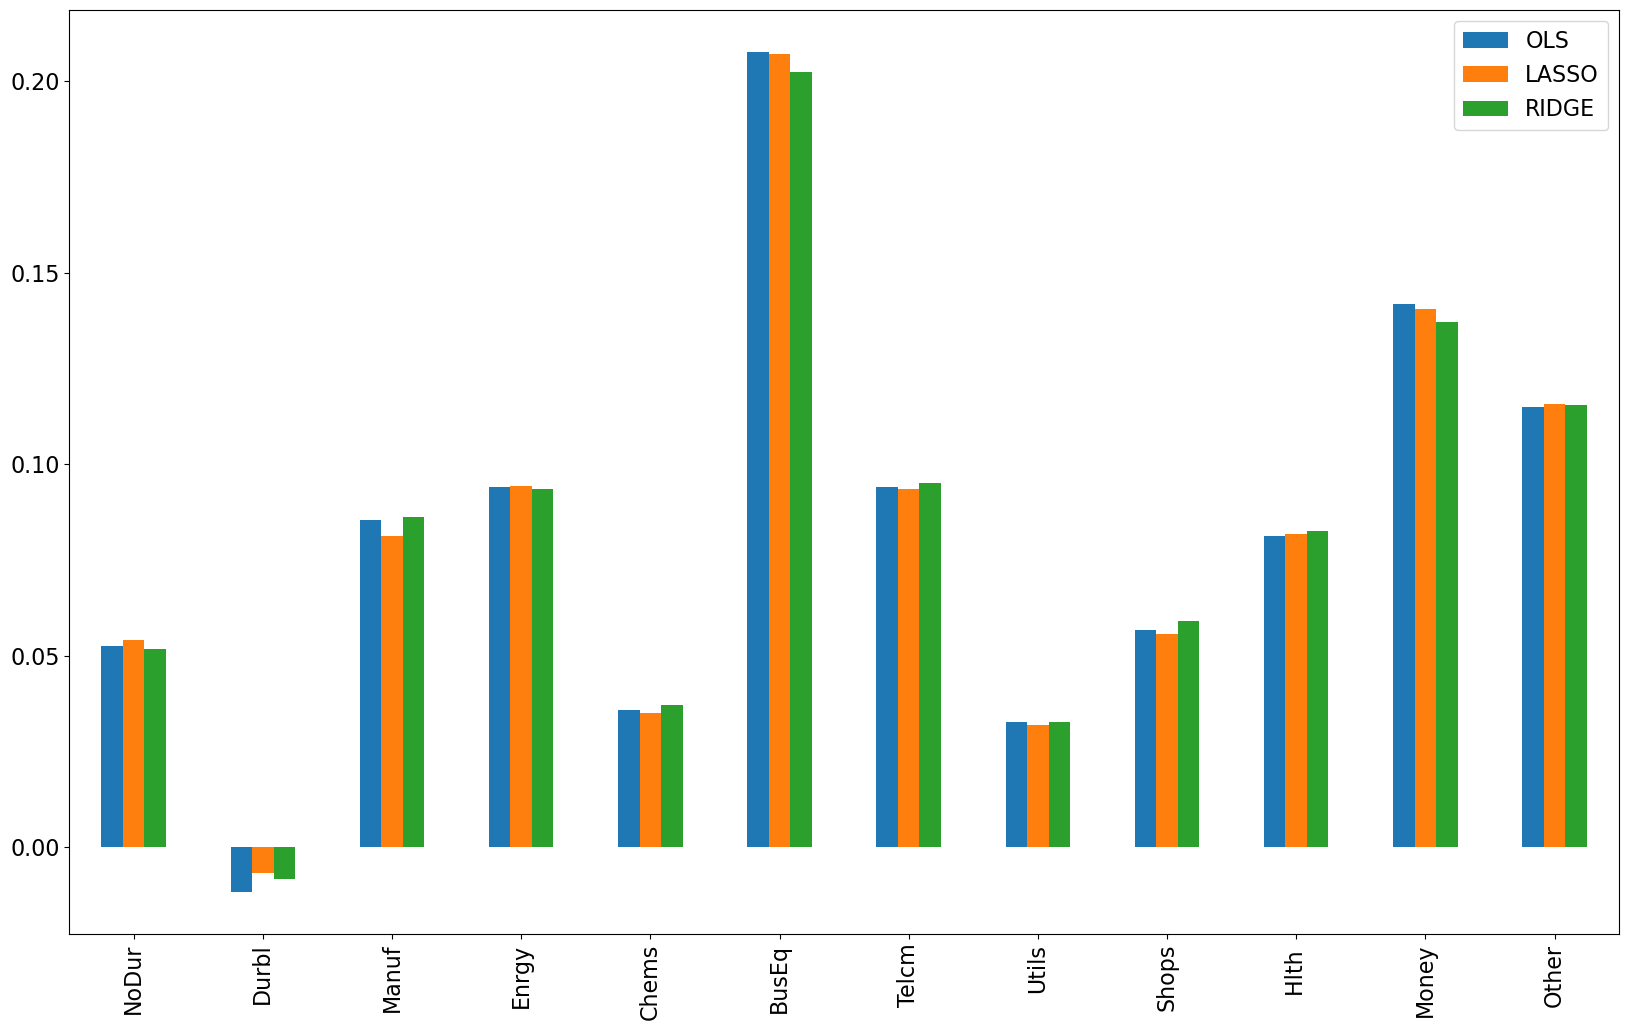

In [10]:
import matplotlib.pyplot as plt
from statsmodels.api import OLS

plt.rc("font", size=16)

ols = OLS(y, x).fit().params

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
_ = pd.DataFrame([ols, lasso_orig, ridge_orig], index=["OLS", "LASSO", "RIDGE"]).T.plot(
    kind="bar", ax=ax
)

#### Explanation

The optimal shrinkage is small and the coefficient are similar to those in OLS.  This might not be the case if the sample size was smaller or the number of regressors was larger.

In [11]:
rescaled_pred = x @ ridge_orig
rescaled_pred

Date
1980-01-31     4.942086
1980-02-29    -1.858135
1980-03-31   -10.235365
1980-04-30     4.700443
1980-05-31     6.367643
                ...    
2014-08-31     4.011852
2014-09-30    -1.877541
2014-10-31     2.074927
2014-11-30     2.099876
2014-12-31    -0.203080
Freq: M, Length: 420, dtype: float64

#### Explanation

With the rescaled coefficients, we can then compute the actual in-sample predictions with the correct scale.

### Exercise 55

Use scikit-learn to scale the standardize the data by changing the scale but not the mean.


In [12]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler(with_mean=False)
y_2d = pd.DataFrame(y)
y_scaler = y_scaler.fit(y_2d)

x_scaler = StandardScaler(with_mean=False)
x_scaler = x_scaler.fit(x)

std_y = y_scaler.transform(y_2d)
std_x = x_scaler.transform(x)

ridge_cv = RidgeCV(alphas=np.linspace(4, 6, 2001), fit_intercept=False)
ridge_cv = ridge_cv.fit(std_x, std_y)
print(f"Optimal alpha : {ridge_cv.alpha_}")

Optimal alpha : 4.87


#### Explanation

scikit-learn contains a number of alternative rescaling methods.  The basic one is `StandardScaler` which by default computes

$$ \tilde{X} = \frac{X-\bar{X}}{\hat{\sigma}_X}.$$

We can set `with_mean=False` to force $\bar{X}=0$.

Here we standardize both x and y using `StandardScaler` and show the results are identical. `StandardScaler` is used by first initializing it, then fitting the coefficients to a dataset.  This computes the mean and standard deviation and lets the same scaler be applied to other data later. It also lets the scaling operation be inverted, so that we can transform some standardized value $Z$ to the same scale as the original data

$$ \ddot{X} = \hat{\sigma}_X Z + \bar{X}.$$

**Note** `StandardScaler` expects a 2-d input, so we need to transform the `Series` version of y to a `DataFrame`.

### Exercise 56

Use the scikit-learn scaler to compute the predicted in-sample values using the Ridge ridge regression.

In [13]:
pred = ridge_cv.predict(std_x)
rescaled_pred = y_scaler.inverse_transform(pred)
pd.Series(rescaled_pred.squeeze())

0       4.942086
1      -1.858135
2     -10.235365
3       4.700443
4       6.367643
         ...    
415     4.011852
416    -1.877541
417     2.074927
418     2.099876
419    -0.203080
Length: 420, dtype: float64

#### Explanation

To make predictions in the original space of the y values, we first predict using the standardized values, and then we use `inverse_transform` of the `y_scaler` to transform the predictions which are for the standardized y back to the original scale. Aside from the loss of the pandas information, we can see these are the same as the predictions above.

### Exercise 57

Use the scalar from scikit-learn to produce out-of-sample forecasts of the two shrinkage estimators and OLS and evaluate the out-of-sample SSE.


In [14]:
# Select the out-of-sample data
y_oos = vwm.loc["2015":, "VWM"]
x_oos = industries["2015":]

# Transform the out-of-sample values
std_x_oos = x_scaler.transform(x_oos)

In [15]:
# Predict using the standardized OOS values
pred = lasso_cv.predict(std_x_oos)
# Ensure that pred is a 2d array with shape (nobs, 1)
pred = pred.reshape((-1, 1))
print(pred.shape)
# Compute OOS residuals by inverting the scale of the prediction
resid_oos = y_oos - np.squeeze(y_scaler.inverse_transform(pred))
lasso_oos_sse = resid_oos @ resid_oos
lasso_oos_sse

(70, 1)


C:\Anaconda\envs\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


19.126359540836944

#### Explanation

The scikit-learn approach makes out-of-sample prediction simple using 3 steps:

1. Standardized out-of-sample x values using the `x_scaler`. **Note**: This must be the same scaler used previously.
2. Make a prediction using the transformed out-of-sample x values.
3. Inverse the transformation of the prediction using `y_scaler`.

**Note**: We _do not_ rescale the out-of-sample y values.

In [16]:
# Specify and fit the model
pred = ridge_cv.predict(std_x_oos)
resid_oos = y_oos - np.squeeze(y_scaler.inverse_transform(pred))
ridge_oos_sse = resid_oos @ resid_oos
ridge_oos_sse

19.50183133359764

#### Explanation

Predictions from ridge regression are virtually identical. The only caveat in the code is thar Ridge likes 2d arrays, and so `pred` is 2d. This needs to be squeezed to 1d before running through `inverse_transform`.

In [17]:
ols_pred = x_oos @ ols
resid_oos = y_oos - ols_pred
ols_oos_sse = resid_oos @ resid_oos
ols_oos_sse

20.150507935326274

#### Explanation

For good measure we can compare to OLS.  We see that both shrinkage methods have outperformed OLS despite the small differences in coefficients.

### Exercise 58

Directly produce out-of-sample forecasts of the two shrinkage estimators and OLS and evaluate the out-of-sample SSE without using scikit-learn.


In [18]:
x_oos = industries["2015":]
direct_pred = x_oos @ ridge_orig

resid = y_oos - direct_pred
ridge_oos_sse = resid @ resid
ridge_oos_sse

19.50183133359772

#### Explanation

It is also possible to directly compute the out-of-sample predictions using the transformed regression coefficients computed previously.  When the coefficients have been transformed, the remainder of the calculation is simple.

Finally, we can compare the predictions using the two methods and see they are identical.

In [19]:
df = pd.DataFrame(direct_pred, columns=["Transformed Coefs"])
df["scikit Scaling"] = y_scaler.inverse_transform(pred)
df.head(10)

,Transformed Coefs,scikit Scaling
Date,,
2015-01-31,-3.363328,-3.363328
2015-02-28,6.203434,6.203434
2015-03-31,-1.435684,-1.435684
2015-04-30,1.100576,1.100576
2015-05-31,1.053263,1.053263
2015-06-30,-1.765861,-1.765861
2015-07-31,0.969392,0.969392
2015-08-31,-5.859802,-5.859802
2015-09-30,-3.124244,-3.124244
